<a href="https://colab.research.google.com/github/shuvoxcd01/NST/blob/master/Neural_Style_Transfer_with_tf_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import os
img_dir = '/tmp/nst'

if not os.path.exists(img_dir):
    os.makedirs(img_dir)

!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/d/d7/Green_Sea_Turtle_grazing_seagrass.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/b/b4/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/0/00/Tuebingen_Neckarfront.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/6/68/Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg
!wget --quiet -P /tmp/nst/https://upload.wikimedia.org/wikipedia/commons/e/ec/Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg
    

wget: missing URL
Usage: wget [OPTION]... [URL]...

Try `wget --help' for more options.


In [0]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False

import numpy as np
from PIL import Image
import time
import functools

import tensorflow as tf
import tensorflow.contrib.eager as tfe

from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K


In [4]:
tf.enable_eager_execution()
print("Eager execution: {}".format(tf.executing_eagerly()))

tf.test.is_gpu_available()

Eager execution: True


True

In [0]:
# Set up some global values here
content_path = '/tmp/nst/Green_Sea_Turtle_grazing_seagrass.jpg'
style_path = '/tmp/nst/The_Great_Wave_off_Kanagawa.jpg'


In [0]:
#Visualize the input

def load_img(path_to_img):
    max_dim = 512
    img = Image.open(path_to_img)
    long = max(img.size)
    scale = max_dim / long
    
    img = img.resize((round(img.size[0] * scale), round(img.size[1] * scale)), Image.ANTIALIAS)
    
    img = kp_image.img_to_array(img)
    
    #We need to broadcast the image array such that it has a batch dimension
    img = np.expand_dims(img, axis=0)
    return img

In [0]:
def imshow(img, title=None):
    #Remove the batch dimension
    out = np.squeeze(img, axis=0)
    #Normalize for display
    out = out.astype('uint8')
    if title is not None:
        plt.title(title)
    plt.imshow(out)

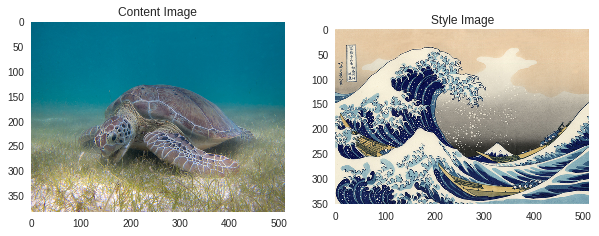

In [38]:
plt.figure(figsize=(10,10))

content = load_img(content_path).astype('uint8')
style = load_img(style_path).astype('uint8')

plt.subplot(1,2,1)
imshow(content, 'Content Image')

plt.subplot(1,2,2)
imshow(style, 'Style Image')

plt.show()

In [0]:
def load_and_process_img(path_to_img):
    img = load_img(path_to_img)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img

In [0]:
def deprocess_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, axis=0)
    assert len(x.shape) ==  3, ("Input to deprocess image must be an image of"
                               "dimension [1, height, width, channel] or [height, width, channel]")
    if len(x.shape) != 3:
        raise ValueError("Invalid input to deprocessing image")
        
    # perform the inverse of the preprocessing step
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    
    x = x[:, :, ::-1]
    
    x = np.clip(x, 0, 255).astype('uint8')
    
    return x

In [0]:
#content layer where will pull our feature maps
content_layers = ['block5_conv2']

#Style layer we're interested in
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [0]:
def get_model():
    """ Creates our model with access to intermediate layers.
    
    This function will load the VGG19 model and access the intermediate layers.
    These layers will then be used to create a new model that will take inupt image
    and return the outputs from these intermediate layers from the VGG model.
    
    Returns:
        retruns a keras model that takes image inputs and outputs the style and content intermediate layers.
    """
    
    #Load out model. We load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    
    #Get output layers corresponding t style and content layers.
    style_outputs = [vgg.get_layer(name).output for name in style_layers]
    content_outputs = [vgg.get_layer(name).output for name in content_layers]
    model_outputs = style_outputs + content_outputs
    
    #Build model
    return models.Model(vgg.input, model_outputs)
    

In [0]:
def get_content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

In [0]:
def gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n =  tf.shape(a)[0]
    gram = tf.matmul(a,a, transpose_a = True) #transpose the first argument
    
    return gram / tf.cast(n, tf.float32)

In [0]:
def get_style_loss(base_style, gram_target):
    """ Expects two images of dimension h, w, c """
    height, width, channels = base_style.get_shape().as_list()
    gram_style = gram_matrix(base_style)
    
    return tf.reduce_mean(tf.square(gram_style - gram_target))
    

In [0]:
#helper function
def get_feature_representations(model, content_path, style_path):
    """Helper function to compute our content and style feature representations.
    
    This function will simply load and preprocess both the content and style images from their path. Then it will feed them
    through the network to obtain the outputs of the intermediate layers.
    
    Arguments:
        model: The model that we are using.
        content_path: The path to the content image.
        style_path: The path to the style image.
        
    Returns:
        returns the style features and the content features.
    
    """
    #load our images in
    content_image = load_and_process_img(content_path)
    style_image = load_and_process_img(style_path)
    
    #compute content and style features
    style_outputs = model(style_image)
    content_outputs = model(content_image)
    
    #Get the style and content feature representations from our model
    style_features = [style_layer[0] for style_layer in style_outputs[ : num_style_layers]]
    content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers : ]]
    
    return style_features, content_features

In [0]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
    """This function will compute the total loss
    
    Arguments:
        model: The model that will give us access to the intermediate layers.
        loss_weights: The weights of each conribution of each loss function.
         (style weight, content weight, and total variation weight)
        init_image: Our initial base image. This image is what we are updating with our optimization process. We apply the
         gradients with respect to the loss we are calculating to this image.
        gram_style_features: precomputed gram matrices corresponding to the defined style layers of interest.
        content_features: Precomputed outputs from defined content layers of interest.
        
    Returns:
        returns the total loss, style loss, content loss, and total variational loss.
    """
    
    style_weight, content_weight = loss_weights
    
    model_outputs = model(init_image)
    
    style_output_features = model_outputs[:num_style_layers]
    content_output_featurs = model_outputs[num_style_layers:]
    
    style_score = 0
    content_score = 0
    
    #Accumulate style_losses from all layers
    weight_per_style_layer = 1.0 / float(num_style_layers)
    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_score += weight_per_style_layer * get_style_loss(comb_style[0],target_style)
        
    #Accumulate content losses from all layers
    weight_per_content_layer = 1.0 / float(num_content_layers)
    for target_content, comb_content in zip(content_features, content_output_featurs):
        content_score += weight_per_content_layer * get_content_loss(comb_content[0], target_content)
        
    style_score *= style_weight
    content_score *= content_weight
    
    #Get total loss
    loss = style_score + content_score
    
    return loss, style_score, content_score

In [0]:
#Compute gradient

def compute_grads(cfg):
    with tf.GradientTape() as tape:
        all_loss = compute_loss(**cfg)
    total_loss = all_loss[0]
    
    return tape.gradient(total_loss, cfg['init_image']), all_loss

In [0]:
#Optimization loop

import IPython.display

def run_style_transfer(content_path, style_path, num_iterations=1000, content_weight=1e3, style_weight=1e-2):
    # We do not want to train our model. So, we set the layers.trainable to False.
    model = get_model()
    for layer in model.layers:
        layer.trainable = False
    
    #Get the style and content feature representations
    style_features, content_features = get_feature_representations(model, content_path, style_path)
    gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
    
    #Set initial image
    init_image = load_and_process_img(content_path)
    init_image = tfe.Variable(init_image, dtype=tf.float32)
    
    #Create our optimizer
    opt = tf.train.AdamOptimizer(learning_rate=0.5, beta1=0.99, epsilon=1e-1)
    
    #For displaying intermediate images
    iter_count = 1
    
    #Store our best result
    best_loss, best_img = float('inf'), None
    
    #Create a nice config
    loss_weights = (style_weight, content_weight)
    cfg = {
        'model':model,
        'loss_weights':loss_weights,
        'init_image':init_image,
        'gram_style_features': gram_style_features,
        'content_features':content_features
    }
    
    # For displaying
    num_rows = 2
    num_cols = 5
    display_interval = num_iterations / (num_rows * num_cols)
    start_time = time.time()
    global_start = time.time()
    
    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means
    
    imgs = []
    
    for i in range(num_iterations):
        grads, all_loss = compute_grads(cfg)
        loss, style_score, content_score = all_loss
        opt.apply_gradients([(grads, init_image)])
        #clipped = tf.clip_by_value(init_image, min_vals, max_vals)
        #init_image.assign(clipped)
        end_time = time.time()
        
        if loss < best_loss:
            best_loss = loss
            best_img = deprocess_img(init_image.numpy())
            
        if i % display_interval == 0:
            start_time = time.time()
            
            plot_img = init_image.numpy()
            plot_img = deprocess_img(plot_img)
            imgs.append(plot_img)
            IPython.display.clear_output(wait=True)
            IPython.display.display_png(Image.fromarray(plot_img))
            print('Iteration:{}'.format(i))
            print('Total loss: {:.4e},'
                 'style loss: {:.4e},'
                 'content_loss: {:.4e}, '
                 'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
    print('Total time: {:.4f}s'.format(time.time() - global_start))
    IPython.display.clear_output(wait = True)
    plt.figure(figsize=(14,4))
    for i, img in enumerate(imgs):
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])

    return best_img, best_loss
        


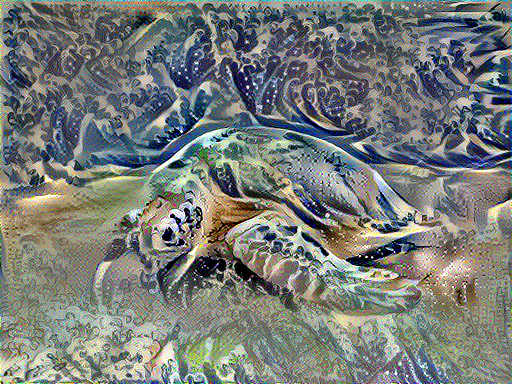

Iteration:500
Total loss: 2.4155e+06,style loss: 1.5163e+06,content_loss: 8.9923e+05, time: 0.1080s


In [0]:
best, best_loss = run_style_transfer(content_path, style_path, num_iterations=1000)

In [0]:
def show_results(best_img, content_path, style_path, show_large_final=True):
  plt.figure(figsize=(10, 5))
  content = load_img(content_path) 
  style = load_img(style_path)

  plt.subplot(1, 2, 1)
  imshow(content, 'Content Image')

  plt.subplot(1, 2, 2)
  imshow(style, 'Style Image')

  if show_large_final: 
    plt.figure(figsize=(10, 10))

    plt.imshow(best_img)
    plt.title('Output Image')
    plt.show()

In [0]:
from google.colab import files

In [47]:
uploaded = files.upload()

Saving Sweta_bday.jpg to Sweta_bday.jpg


In [48]:
!ls

hbd_style.png  Photo0800.jpg  Sweta_bday.jpg
monalisa.jpg   sample_data    Toma.jpg


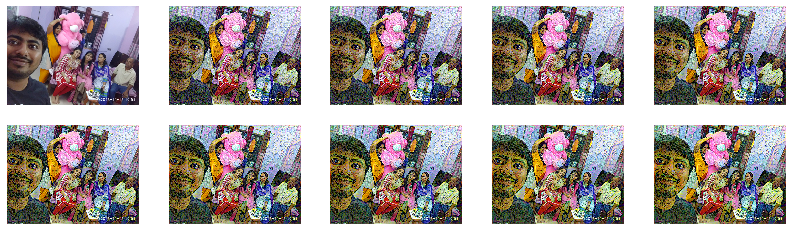

In [56]:
best, best_loss = run_style_transfer('Sweta_bday.jpg', 'hbd_style.png', num_iterations=5000)

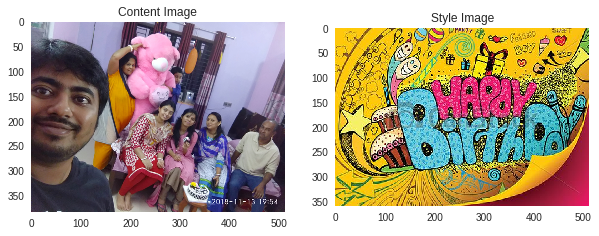

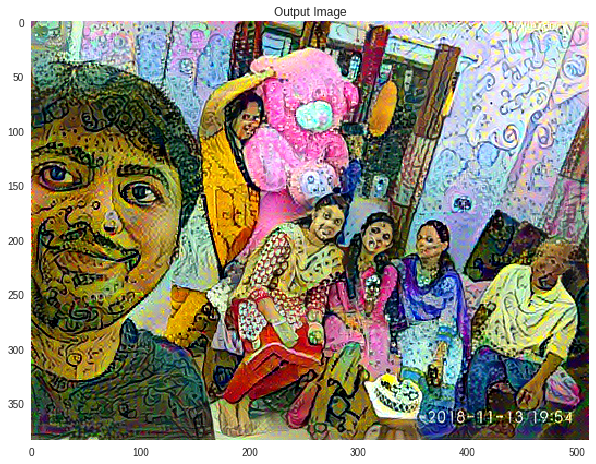

In [57]:
show_results(best, 'Sweta_bday.jpg', 'hbd_style.png')